In [35]:
# sky_hotspots_density_signal_test.ipynb
# Authors: Stephan Meighen-Berger
# Performs a signal hotspot check using a density approach

In [36]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
from tqdm import tqdm
from scipy.interpolate import UnivariateSpline
import matplotlib.cm as cm
from scipy.optimize import root_scalar

In [37]:
# picture path
PICS = '../pics/'

In [38]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [39]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.
mark_s = 10
# params
mag_fit = 1.
colors = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
alphas = [0.2, 0.4, 0.6, 0.8, 1.]
# labels_mass = ['1\;TeV', '100\;TeV', '10\;PeV', '30\;TeV']
linest = ['-', '--', '-.', ':']

In [40]:
def ice_parser(filename):
    store = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row_num, row in enumerate(reader):
            if row_num == 0:
                continue
            store.append(row[0].split())
    store = np.array(store, dtype=float)
    return store
# log10(E_nu/GeV)_min, log10(E_nu/GeV)_max, Dec_nu_min[deg], Dec_nu_max[deg], A_Eff[cm^2]
eff_areas = [
    '../data/icecube_10year_ps/irfs/IC40_effectiveArea.csv',
    '../data/icecube_10year_ps/irfs/IC59_effectiveArea.csv',
    '../data/icecube_10year_ps/irfs/IC79_effectiveArea.csv',
    '../data/icecube_10year_ps/irfs/IC86_I_effectiveArea.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_effectiveArea.csv',
]
eff_dic = {
    0: ice_parser(eff_areas[0]),
    1: ice_parser(eff_areas[1]),
    2: ice_parser(eff_areas[2]),
    3: ice_parser(eff_areas[3]),
    4: ice_parser(eff_areas[4]),
    5: ice_parser(eff_areas[4]),
    6: ice_parser(eff_areas[4]),
    7: ice_parser(eff_areas[4]),
    8: ice_parser(eff_areas[4]),
    9: ice_parser(eff_areas[4]),
}

In [41]:
# MJD, log10(E/GeV), AngErr[deg], RA[deg], Dec[deg], Azimuth[deg], Zenith[deg]
data_sets = [
    '../data/icecube_10year_ps/events/IC40_exp.csv',
    '../data/icecube_10year_ps/events/IC59_exp.csv',
    '../data/icecube_10year_ps/events/IC79_exp.csv',
    '../data/icecube_10year_ps/events/IC86_I_exp.csv',
    '../data/icecube_10year_ps/events/IC86_II_exp.csv',
    '../data/icecube_10year_ps/events/IC86_III_exp.csv',
    '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
    '../data/icecube_10year_ps/events/IC86_V_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
]
event_dic = {
    0: ice_parser(data_sets[0]),
    1: ice_parser(data_sets[1]),
    2: ice_parser(data_sets[2]),
    3: ice_parser(data_sets[3]),
    4: ice_parser(data_sets[4]),
    5: ice_parser(data_sets[5]),
    6: ice_parser(data_sets[6]),
    7: ice_parser(data_sets[7]),
    8: ice_parser(data_sets[8]),
    9: ice_parser(data_sets[9]),
}

In [42]:
# Constants
seconds = 60.
minutes = 60.
days = seconds * minutes * 24

In [43]:
# MJD, log10(E/GeV), AngErr[deg], RA[deg], Dec[deg], Azimuth[deg], Zenith[deg]
uptime_sets = [
    '../data/icecube_10year_ps/uptime/IC40_exp.csv',
    '../data/icecube_10year_ps/uptime/IC59_exp.csv',
    '../data/icecube_10year_ps/uptime/IC79_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_I_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_II_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_III_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_IV_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_V_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_VI_exp.csv',
    '../data/icecube_10year_ps/uptime/IC86_VII_exp.csv',
]
uptime_dic = {
    0: ice_parser(uptime_sets[0]),
    1: ice_parser(uptime_sets[1]),
    2: ice_parser(uptime_sets[2]),
    3: ice_parser(uptime_sets[3]),
    4: ice_parser(uptime_sets[4]),
    5: ice_parser(uptime_sets[5]),
    6: ice_parser(uptime_sets[6]),
    7: ice_parser(uptime_sets[7]),
    8: ice_parser(uptime_sets[8]),
    9: ice_parser(uptime_sets[9]),
}
uptime_tot_dic = {}
for year in range(10):
    uptime_tot_dic[year] = np.sum(np.diff(uptime_dic[year])) * days

In [44]:
# Loading smearing
# log10(E_nu/GeV)_min, log10(E_nu/GeV)_max, Dec_nu_min[deg], Dec_nu_max[deg], log10(E/GeV), PSF_min[deg], PSF_max[deg],
# AngErr_min[deg], AngErr_max[deg], Fractional_Counts
smearing_sets = [
    '../data/icecube_10year_ps/irfs/IC40_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC59_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC79_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_I_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
    '../data/icecube_10year_ps/irfs/IC86_II_smearing.csv',
]
smearing_dic = {
    0: ice_parser(smearing_sets[0]),
    1: ice_parser(smearing_sets[1]),
    2: ice_parser(smearing_sets[2]),
    3: ice_parser(smearing_sets[3]),
    4: ice_parser(smearing_sets[4]),
    5: ice_parser(smearing_sets[5]),
    6: ice_parser(smearing_sets[6]),
    7: ice_parser(smearing_sets[7]),
    8: ice_parser(smearing_sets[8]),
    9: ice_parser(smearing_sets[9]),
}

In [45]:
def smearing_function(true_e, true_dec, year):
    # Returns the smeared reconstructed values
    e_test = true_e
    angle_test = true_dec
    local_smearing = smearing_dic[year]
    cross_check_smear_egrid = (local_smearing[:, 1] + local_smearing[:, 0])/2.
    idE = np.abs(cross_check_smear_egrid - e_test).argmin()
    all_near_e = (np.where(cross_check_smear_egrid == cross_check_smear_egrid[idE])[0])
    cross_check_smear_theta = (local_smearing[:, 2] + local_smearing[:, 3])/2.
    idtheta = np.abs(cross_check_smear_theta - angle_test).argmin()
    all_near_theta = (np.where(cross_check_smear_theta == cross_check_smear_theta[idtheta])[0])
    elements_of_interest = np.intersect1d(all_near_e, all_near_theta)
    tmp_local_smearing = local_smearing[elements_of_interest]
    smearing_e_grid = np.unique(tmp_local_smearing[:, 4])
    smearing_fraction = []
    for smearing_e_loop in smearing_e_grid:
        idE = np.abs(tmp_local_smearing[:, 4] - smearing_e_loop).argmin()
        all_near_e = (np.where(tmp_local_smearing[:, 4] == tmp_local_smearing[:, 4][idE])[0])
        smearing_fraction.append(np.sum(tmp_local_smearing[all_near_e][:, -1]))
    # Normalizing
    smearing_fraction = np.array(smearing_fraction) / np.trapz(smearing_fraction, x=smearing_e_grid)
    return smearing_e_grid, smearing_fraction

In [46]:
m_eborders = np.logspace(4., 8., 41)
m_ewidths = np.diff(m_eborders)
m_egrid = np.sqrt(m_eborders[1:]*m_eborders[:-1])

In [47]:
def effective_area_func(injection_id, theta, year):
    # Apply the effective area to the simulation and return unsmeared counts
    cross_check_egrid = (eff_dic[year][:, 1] + eff_dic[year][:, 0])/2.
    cross_check_theta = (eff_dic[year][:, 2] + eff_dic[year][:, 3])/2.
    eff_areas = []
    check_angle = (theta)
    energy = m_egrid[injection_id]
    loge = np.log10(energy)
    idE = np.abs(cross_check_egrid - loge).argmin()
    all_near = (np.where(cross_check_egrid == cross_check_egrid[idE])[0])
    idTheta = np.abs(cross_check_theta[all_near] - check_angle).argmin()
    eff_areas.append(eff_dic[year][all_near, -1][idTheta])
    loc_eff_area = np.array(eff_areas)
    unsmeared_counts = m_ewidths[injection_id] * loc_eff_area * uptime_tot_dic[year] * 2. * np.pi
    return unsmeared_counts

In [48]:
def sim_to_dec(injection_id, theta, year):
    # Converts simulation data to detector data
    unnormalized_counts = effective_area_func(injection_id, theta, year)
    log_egrid = np.log10(m_egrid)
    smeared = []
    check_angle = (theta)
    smearing_e, smearing = smearing_function(log_egrid[injection_id],
                                                check_angle, year)
    spl = UnivariateSpline(smearing_e, smearing * unnormalized_counts,
                            k=1, s=0, ext=1)
    smeared = spl(log_egrid)
    return smeared

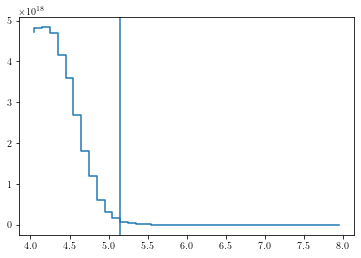

In [49]:
plt.step(np.log10(m_egrid), sim_to_dec(11, 5., 8))
plt.axvline(np.log10(m_egrid[11]))

In [50]:
# Loading weights
def weight_constructor(path_to_file: str) -> UnivariateSpline:
    """ constructes the energy weights for the IceCube events

    Parameters
    ----------
    path_to_file : str
        The theoretical preidcitons for the counts

    Returns
    -------
    weights : UnivariateSpline
        Spline which returns the weight corresponding to the input energy
        as log_10(E/GeV)
    """
    theoretical_predictions = pickle.load(open(path_to_file, "rb"))
    egrid = theoretical_predictions[0]
    weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])
    # weights_arr[weights_arr > 1] = 1
    return UnivariateSpline(egrid, weights_arr, k=1, s=0)
weights = weight_constructor("..\\data\\simulated_data_bkgrd_store_benchmark.pkl")

C:\Users\steph\AppData\Local\Temp/ipykernel_9368/1171514631.py:18: RuntimeWarning: divide by zero encountered in true_divide
  weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])
C:\Users\steph\AppData\Local\Temp/ipykernel_9368/1171514631.py:18: RuntimeWarning: invalid value encountered in true_divide
  weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])


In [51]:
def data_filter(event_dic, energy_range, angle_range, years):
    # filters the data in energy and angle
    filtered_dic = {}
    for year in years:
        # where method is faster as basic slicing
        energy_filter_1 = event_dic[year][np.where(event_dic[year][:, 1] < energy_range[1])]
        energy_filter_2 = energy_filter_1[np.where(energy_filter_1[:, 1] > energy_range[0])]
        high_angle = angle_range[1]
        angle_filter_1 = energy_filter_2[np.where(energy_filter_2[:, 4] < high_angle)]
        low_angle = angle_range[0]
        angle_filter_2 = angle_filter_1[np.where(angle_filter_1[:, 4] > low_angle)]
        filtered_dic[year] = angle_filter_2
    return filtered_dic
filtered_data = data_filter(event_dic, [4., 9.], [0., 10.], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [52]:
# Construct weighted events
def weighted_events(event_dic, weight_func, years):
    weighted_data = []
    for year in years:
        weighted_data.append(np.array([
            event_dic[year][:, 3],
            event_dic[year][:, 4],
            weight_func(event_dic[year][:, 1]),
            event_dic[year][:, 2]
        ]))
        weighted_data[-1] = weighted_data[-1].T
    return np.concatenate([weighted_data[year] for year in years])
weighted_data = weighted_events(filtered_data, weights, range(10))

In [53]:
# The sky grid
minimal_resolution = 0.2
ra_grid = np.arange(0., 360., 0.2)
decl_grid = np.arange(0., 10., 0.2)

In [54]:
# Binning function
def binning_function(event_dic, ra_grid, decl_grid):
    # The density grid
    density_grid = np.zeros((len(decl_grid), len(ra_grid)))
    for event in event_dic:
        # Finding grid points to add to
        # RA
        single_ra = False
        idra_low = (np.abs(ra_grid - (event[0] - event[3]))).argmin()
        idra_high = (np.abs(ra_grid - (event[0] + event[3]))).argmin()
        if idra_high == idra_low:
            single_ra = True
        # Declination
        single_dec = False
        iddec_low = (np.abs(decl_grid - (event[1] - event[3]))).argmin()
        iddec_high = (np.abs(decl_grid - (event[1] + event[3]))).argmin()
        if iddec_low == iddec_high:
            single_dec = True
        # Binning
        if (not single_ra) and (not single_dec):
            density_grid[iddec_low:iddec_high, idra_low:idra_high] += event[2]
        elif single_ra and (not single_dec):
            density_grid[iddec_low:iddec_high, idra_low] += event[2]
        elif (not single_ra) and single_dec:
            density_grid[iddec_low, idra_low:idra_high] += event[2]
        else:
            density_grid[iddec_low, idra_low] += event[2]
    return density_grid
density_grid = binning_function(weighted_data, ra_grid, decl_grid)

In [55]:
def coordinate_trafo(radians):
    new_grid = np.copy(radians)
    new_grid[new_grid > np.pi] = new_grid[new_grid > np.pi] - 2. * np.pi
    return new_grid

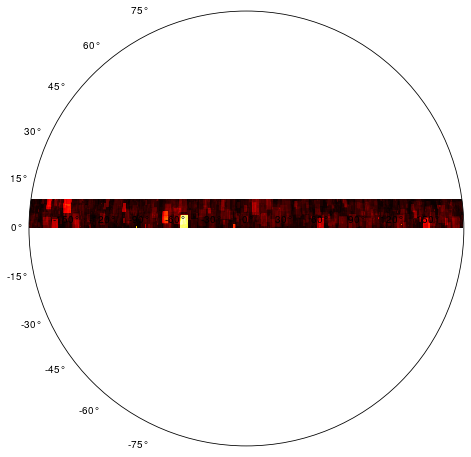

In [56]:
# Using a projection so others have something to look at
fig = plt.figure(figsize=(10, 8))
plt.subplot(projection="mollweide")
traf_RA = coordinate_trafo(np.deg2rad(ra_grid))
plt.imshow(density_grid,
           extent=(np.amin(traf_RA), np.amax(traf_RA),
                   np.amin(np.deg2rad(decl_grid)),
                   np.amax(np.deg2rad(decl_grid))),
           cmap=cm.hot, origin='lower')
plt.savefig("..\\pics\\heat_skymap.png", dpi=100)

In [57]:
# Signal density constructor
def signal_density_constructor(energy_id, number_of_sources,
                               flux_norm, seed, angle_uncer=0.5):
    rand_state = np.random.RandomState(seed)
    declination_sample = rand_state.uniform(
        0., 10., size=(number_of_sources)
    )
    ra_sample = rand_state.uniform(
        0., 360., size=(number_of_sources)
    )
    years = rand_state.randint(0, 9, size=(number_of_sources))
    count_distros = np.array([
        sim_to_dec(energy_id, declination_sample[ids], years[ids]) * flux_norm
        for ids in range(number_of_sources)
    ])
    events = np.array([[
        rand_state.poisson(counts) for counts in count_distro
    ] for count_distro in count_distros])
    reweighted_events = np.array([
        set_events * weights(np.log10(m_egrid))
        for set_events in events
    ])
    density_grid = np.zeros((len(decl_grid), len(ra_grid)))
    # Binning
    for set_id in range(number_of_sources):
        for event in reweighted_events[set_id]:
            # Finding grid points to add to
            # RA
            single_ra = False
            idra_low = (
                np.abs(ra_grid - (ra_sample[set_id] - angle_uncer))
            ).argmin()
            idra_high = (
                np.abs(ra_grid - (ra_sample[set_id] + angle_uncer))
            ).argmin()
            if idra_high == idra_low:
                single_ra = True
            # Declination
            single_dec = False
            iddec_low = (
                np.abs(decl_grid - (declination_sample[set_id] - angle_uncer))
            ).argmin()
            iddec_high = (
                np.abs(decl_grid - (declination_sample[set_id] + angle_uncer))
            ).argmin()
            if iddec_low == iddec_high:
                single_dec = True
            # Binning
            if (not single_ra) and (not single_dec):
                density_grid[iddec_low:iddec_high, idra_low:idra_high] += (
                    event
                )
            elif single_ra and (not single_dec):
                density_grid[iddec_low:iddec_high, idra_low] += (
                    event
                )
            elif (not single_ra) and single_dec:
                density_grid[iddec_low, idra_low:idra_high] += (
                    event
                )
            else:
                density_grid[iddec_low, idra_low] += (
                    event
                )
    return density_grid

In [58]:
signal_density = signal_density_constructor(
    21, 100, 1e-21, 10, angle_uncer=1.5
)
signal_density[signal_density > 0]

array([10.57364667, 10.57364667, 10.57364667, ...,  5.03115155,
        5.03115155,  5.03115155])

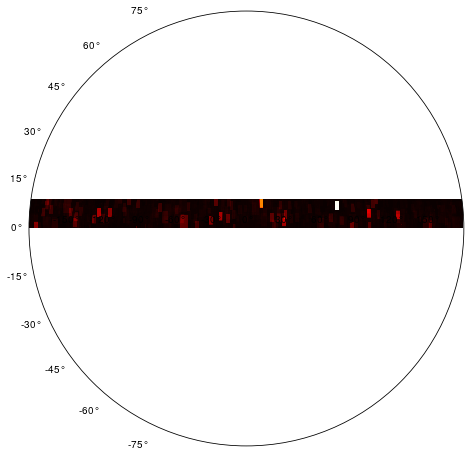

In [59]:
# Using a projection so others have something to look at
fig = plt.figure(figsize=(10, 8))
plt.subplot(projection="mollweide")
traf_RA = coordinate_trafo(np.deg2rad(ra_grid))
plt.imshow(density_grid + signal_density,
           extent=(np.amin(traf_RA), np.amax(traf_RA),
                   np.amin(np.deg2rad(decl_grid)),
                   np.amax(np.deg2rad(decl_grid))),
           cmap=cm.hot, origin='lower')
plt.savefig("..\\pics\\heat_skymap_signal.png", dpi=100)

In [60]:
set_size = 1000
samples = 10000

In [61]:
def bkgrd_test_statistic_calc(samples=1000,
                              setsize=1000):
    sets = int(samples / setsize)
    totals = []
    for set_id in range(sets):
        density_sets = pickle.load(
            open("..\\data\\storage\\density_sets_%d.p" % set_id, "rb")
        )
        tmp_total = np.zeros_like(density_sets[0])
        for density_set in density_sets:
            tmp_total += density_set
        tmp_total = tmp_total / setsize
        totals.append(tmp_total)
    average_density = np.zeros_like(totals[0])
    for total in totals:
        average_density += total
    average_density = average_density / sets  # Normalized
    # Finding the average test statistic
    chi2_bkgrd_all = []
    for set_id in range(sets):
        density_sets = pickle.load(
            open("..\\data\\storage\\density_sets_%d.p" % set_id, "rb")
        )
        # Comparing to the scrambled data
        chi2_bkgrd_set = np.array([
        np.sum(
                np.nan_to_num((density_set - average_density)**2. / average_density)
            )
            for density_set in density_sets
        ])
        chi2_bkgrd_all.append(chi2_bkgrd_set)
    chi2_test_bkgrd = np.mean(chi2_bkgrd_all)
    return chi2_test_bkgrd, average_density
chi2_background_statistic, bkgrd_density = (
    bkgrd_test_statistic_calc(samples=samples, setsize=set_size)
)
pickle.dump([chi2_background_statistic, bkgrd_density],
            open("..\\data\\test_set.pkl", "wb"))

In [62]:
chi2_background_statistic

77103.88207356661

In [63]:
def improved_comparison_signal(signals, q_bkgrd, bkgrd_density):
    chi_data = []
    for signal in signals:
        chi_data.append(np.sum(np.nan_to_num(
            (signal)**2. / bkgrd_density
        )))
    chi_data = np.array(chi_data)
    subset = chi_data[chi_data > q_bkgrd]
    fraction = len(subset) / len(chi_data)
    return fraction

In [64]:
signal_densities = np.array([
    signal_density_constructor(
        21, 2, 1e-20, seed, angle_uncer=1.
    ) for seed in range(100)
])

In [65]:
cl_lim = (
    improved_comparison_signal(signal_densities,
        chi2_background_statistic, bkgrd_density
    )
)

In [67]:
cl_lim_all = []
population = [1, 5, 10]
flux_scan = np.logspace(-24, -14, 51)
ide_scan = [0, 20, 30]
for ide in tqdm(ide_scan):
    cl_lim_store = []
    for pop in population:
        cl_tmp = []
        for flux in flux_scan:
            signal_densities = np.array([
                signal_density_constructor(
                    ide, pop, flux, seed, angle_uncer=1.
                ) for seed in range(100)
            ])
            cl_lim = (
                improved_comparison_signal(signal_densities,
                    chi2_background_statistic, bkgrd_density)
            )
            cl_tmp.append(cl_lim)
        cl_lim_store.append(cl_tmp)
    cl_lim_all.append(cl_lim_store)

100%|██████████| 3/3 [1:21:47<00:00, 1635.98s/it]


In [85]:
# Fetching the flux values
population_plot = range(len(population))
plot_grid_y = []
for ide in range(len(ide_scan)):
    tmp_plot_grid = []
    for pop in population_plot:
        spline = UnivariateSpline(flux_scan, cl_lim_all[ide][pop], k=1, s=0)
        def root_flux(flux):
            return (spline(10**flux) - 0.9)
        sol = root_scalar(root_flux, bracket=[-26, -13], method='brentq')
        value = sol.root
        tmp_plot_grid.append(value)
    plot_grid_y.append(tmp_plot_grid)

In [88]:
for energy_id in ide_scan:
    print(np.log10(m_egrid[energy_id])

11220.18454301963
1122018.4543019629
11220184.54301963


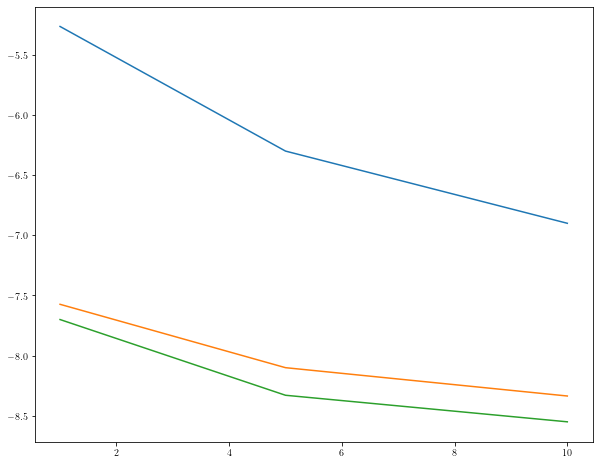

In [92]:
# Visualizing the limits
fig = plt.figure(figsize=(10, 8))
for ide in range(len(ide_scan)):
    plt.plot(population, np.array(plot_grid_y[ide])+np.log10(m_egrid[ide_scan[ide]]**2))
plt.savefig("..\\pics\\source_limits_1PeV.png", dpi=100)